# Optimisation de la trajectoire d'un UAV
### Résolution avec la méthode discrètre LQT (Linear Quadratic Tracking) 

Abraham Bhérer-Constant 1906705

Théo Vernhes 1781853

Packages utilisés :

In [ ]:
#using Pkg
#Pkg.add("Plots")
#Pkg.add("LinearAlgebra")

In [1]:
using Plots
using LinearAlgebra
using Printf

In [2]:
# include("model.jl")

sol_2_trajectory (generic function with 1 method)

### Problèmes rencontrés

Intégration de la gravité dans le modèle dynamique : RÉSOLU

Disctrétisation du modèle linéaire : RÉSOLU

Modification de l'algorithme LQT [eqn 36] : RÉSOLU (cf Discrete-Time Linear Quadratic Tracking System dans OPTIMAL CONTROL SYSTEMS par R. C. Dorf)

Matrice de poids optimale : 

    - R doit être une matrice symétrique définie positive
    
Solution diverge :

    - X_star diverge vers l'infini (L et Lg reste constant. Cela peut venir de la ? ou g)
    
    - X_star[5 et 6] = 0 pour tout k (doit tendre proche de 0 mais n'est pas constant ni exact)

## Modèle Dynamique Linéarisé

Parmètres du système dynamique :

In [3]:
Kt = 0.1 ;
W = 4.7088 ; # en N
gr = 9.81 ; # en m/s^2
m = 0.485  ; # en kg
gravity = vcat(zeros(11, 1), - gr)

# Valeurs posées arbitrairement
d = 0.35 ; # en m
I_x = 3.4e-3 ;
I_y = 3.4e-3 ;
I_z = 4.7e-3 ; 

U1_ini = W ; 

Paramètres de la simulation :

In [4]:
ti = 0 ; # temps initial en secondes
tf = 60 ; # temps de simulation en secondes
h = 0.01 ; # pas de temps en secondes
t = range(0, stop= tf , step = h)*I ; # vecteur temps

kf = size(t, 1) ;
k = kf ;

Construction du vecteur trajectoire désirée :

In [5]:
x = vcat(range(0, stop= 30 , step = h), range(30 - h, stop= 0 , step = -h)) ;
y = vcat(zeros(3000, 1), 5 .* ones(3001, 1))
z = ones(size(t))
z[(t .> 15) .& (t .<= 30)] = range(1 + h, stop = 16, step = h) ;
z[(t .> 30) .& (t .<= 45 )] = range(16 - h, stop = 1, step = - h) ;

In [6]:
# Éstimation des vitesses avec la méthode des différences finies :
x_dot_i = (x[2] - x[1])/h ;
x_dot_f = (x[kf] - x[kf - 1])/h ;
x_dot_n = (x[3:kf] - x[1:kf - 2]) ./ (2 *h ) ;

x_dot = vcat(x_dot_i, x_dot_n, x_dot_f)


y_dot_i = (x[2] - x[1])/h ;
y_dot_f = (x[kf] - x[kf - 1])/h ;
y_dot_n = (x[3:kf] - x[1:kf - 2]) ./ (2 *h ) ;

y_dot = vcat(y_dot_i, y_dot_n, y_dot_f)


z_dot_i = (x[2] - x[1])/h ;
z_dot_f = (x[kf] - x[kf - 1])/h ;
z_dot_n = (x[3:kf] - x[1:kf - 2]) ./ (2 *h ) ;

z_dot = vcat(z_dot_i, z_dot_n, z_dot_f) ;

In [7]:
# Vecteur trajectoire désirée: 
# r = [ϕ ϕ_dot θ θ_dot ψ ψ_dot x x_dot y y_dot z z_dot]'
r = hcat(zeros(kf, 6), x, x_dot, y, y_dot, z, z_dot)' ;

### Construction des matrice du système dynamique linéarisé

In [ ]:
#A, B, C = buildLinearSystem()

#### Matrice d'état A

In [8]:
A = zeros( 12, 12) ;
# Index matrice : A[ligne, colonne]
for i in 1:size( A, 2)
    if mod( i, 2) !== 0
        A[ i, i+1] = 1 ;
    end
end

A[ 8, 3] = gr ;
A[ 8, 8] = -Kt / m ;

A[ 10, 1] = -gr ;
A[ 10, 10] = -Kt / m ;

A[ 12, 12] = - Kt / m ;

In [ ]:
A

#### Matrice d'entrée B

In [9]:
B = zeros(12, 4) ;
B[2, 2] = d / I_x ;
B[4, 3] = d / I_y ;
B[6, 4] = 1 / I_z ;
B[12, 1] = 1 / m ;

#### Matrice de sortie C

In [10]:
C = I(12) ;

## Calcul de la trajectoire et des contrôles optimaux

### Discrétisation du modèle

x[k+1] = x[k] + h * x_dot[k]

x[k+1] = x[k] + h * (A * x[k] + B * U[k] + gravity) où h : pas de temps (scalaire)

x[k+1] = (I + A * h) * x[k] + B * h * U[k] + gravity * h

x[k+1] = Ad * x[k] + Bd * U[k] + gravity * h


y[k+1] = C * x[k+1]

y[k+1] = Cd * x[k+1]

In [11]:
Ad = I + A * h ;

Bd = B * h ;

Cd = C ;

Calcul des paramètres de la méthode LQT

In [33]:
# Matrice de poids d'état
Q = Diagonal([100, 50, 10, 5, 0, 0, 100, 1, 100, 1, 1000, 0.1]);
#Q = I
#Q = Diagonal([100, 5, 100, 5, 100, 5, 100, 5, 100, 5, 100, 5]);

# Matrice de poids de contrôle
#R = Diagonal([10, 0, 0, 0]) ;
#R = Diagonal([100, 100, 100, 100]) ;
R = I

# Calcul des conditions finales et des solutions au temps final (kf) :
F = zeros(12,12) ;

Pk = Cd' * F * Cd ;
gk = Cd' * F * r[1:12, kf] ;

U_star = zeros(4, size(r,2)) ;
X_star = zeros(size(r)) ;
X_star[1:12, 1] = r[1:12, 1] ;

Paramètres invariants dans le temps :

In [19]:
V = Cd' * Q * Cd ;

E = Bd * inv(R) * Bd' 

12×12 Matrix{Float64}:
 0.0  0.0      0.0  0.0      0.0  0.0      …  0.0  0.0  0.0  0.0  0.0
 0.0  1.05969  0.0  0.0      0.0  0.0         0.0  0.0  0.0  0.0  0.0
 0.0  0.0      0.0  0.0      0.0  0.0         0.0  0.0  0.0  0.0  0.0
 0.0  0.0      0.0  1.05969  0.0  0.0         0.0  0.0  0.0  0.0  0.0
 0.0  0.0      0.0  0.0      0.0  0.0         0.0  0.0  0.0  0.0  0.0
 0.0  0.0      0.0  0.0      0.0  4.52694  …  0.0  0.0  0.0  0.0  0.0
 0.0  0.0      0.0  0.0      0.0  0.0         0.0  0.0  0.0  0.0  0.0
 0.0  0.0      0.0  0.0      0.0  0.0         0.0  0.0  0.0  0.0  0.0
 0.0  0.0      0.0  0.0      0.0  0.0         0.0  0.0  0.0  0.0  0.0
 0.0  0.0      0.0  0.0      0.0  0.0         0.0  0.0  0.0  0.0  0.0
 0.0  0.0      0.0  0.0      0.0  0.0      …  0.0  0.0  0.0  0.0  0.0
 0.0  0.0      0.0  0.0      0.0  0.0         0.0  0.0  0.0  0.0  0.000425125

In [34]:
# DEBUG

 store_g = [] ;
 store_normg = [] ;
 push!(store_g, g)
 store_Lg = [] ;
 store_normLg = [] ;
 store_L = [] ;
 store_normL = [] ;
L = [];
Lg = [] ;
 P = [] ;
g = [] ;
push!(P, Pk)
push!(g, gk)


1-element Vector{Any}:
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [35]:
k = kf

6001

### Backtracking avec LQT

In [36]:
while k !== 1
    k -= 1 ;
    
    Lk = (R + Bd' * Pk * Bd) \ Bd' * Pk * Ad ;
    Lgk = (R + Bd' * Pk * Bd) \ Bd' ;
    push!(L, Lk)
push!(Lg, Lgk)
    
    #To check
    gk = (Ad' - Ad' * Pk / (I + E * Pk) * E) * gk + Cd' * Q * r[1:12, k] ;
    #gk = Ad' * (I - (inv(Pk) + E) \ E) * gk + Cd' * Q * r[1:12, k] ;
    Pk = Ad' * Pk / (I + E * Pk) * Ad + V;
    push!(P, Pk)
push!(g, gk)
    # DEBUG
  #   push!(store_g, g) ;
   #  push!(store_normg, norm(g)) ;
    # push!(store_Lg, Lg) ;
     #push!(store_normLg, norm(Lg)) ;
     #push!(store_L, L) ;
     #push!(store_normL, norm(L)) ;
end

In [39]:
L = L[kf:-1:1]
Lg = Lg[kf:-1:1]

g = g[kf:-1:1]
P = P[kf:-1:1]

6001-element Vector{Any}:
 [-7.858929751381764e-13, -7.813334549117223e-15, 1484.0536084978676, 16.22489917429484, 0.0, 0.0, 1795.105232566273, 793.7846102489327, -99.99999999999997, 1.8784973576657649e-13, 18540.690724763568, 1622.3871782053266]
 [-8.058766648388169e-13, -8.008049849301069e-15, 1509.134059234325, 16.494212113031814, 0.0, 0.0, 1856.3507567894549, 811.2041067310136, -99.99999999999996, 1.9662049766111522e-13, 18540.690724763568, 1622.3871782053266]
 [-8.2594664418423e-13, -8.203314122285764e-15, 1534.214509970782, 16.763525051768788, 0.0, 0.0, 1917.5962810126368, 828.6236032130944, -99.99999999999994, 2.0550228185811648e-13, 18540.690724763568, 1622.3871782053266]
 [-8.460736562026727e-13, -8.399275139225325e-15, 1559.2949607072392, 17.03283799050576, 0.0, 0.0, 1978.8418052358188, 846.0430996951752, -99.99999999999993, 2.1471713296250527e-13, 18540.690724763568, 1622.3871782053266]
 [-8.662732594084824e-13, -8.59618785787164e-15, 1584.3754114436963, 17.30215092924274, 0

In [43]:
for k in 1:kf - 1
    #X_star[1:12 , k] = (Ad - Bd * L) \ (X_star[1:12, k+1] - Bd * Lg * g) ; # - gravity * h);
    X_star[1:12 , k+1] = (Ad - Bd * L[k]) * X_star[1:12, k] + Bd * Lg[k] * g[k+1] ; # - gravity * h);
    U_star[1:4,  k] = - L[k] * X_star[1:12, k] + Lg[k] * g[k+1] ;
end

## Résultats de l'algorithme

Graphique : X(t)

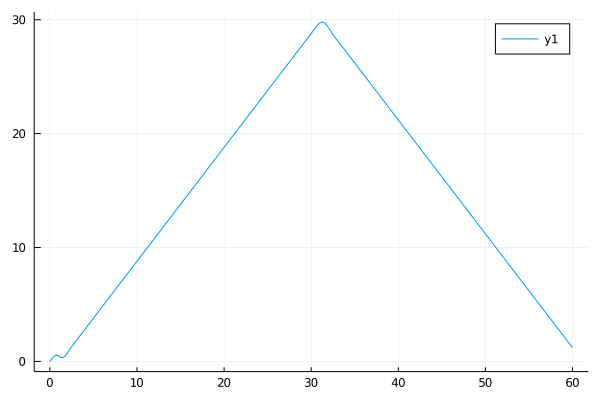

In [44]:
plot(t, X_star[7, :])

Graphique : Y(t)

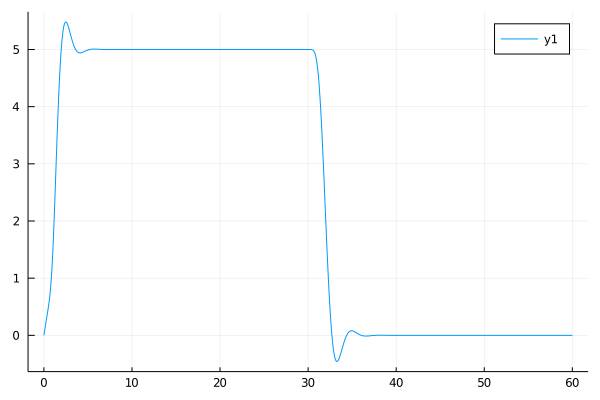

In [45]:
plot(t, X_star[9, :])

Graphique : Z(t)

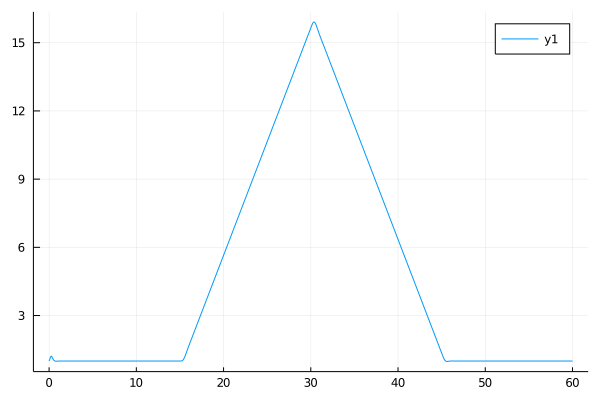

In [46]:
plot(t, X_star[11, :])

In [ ]:
plot(t[3000:kf], X_star[11, 3000:kf])

La solution diverge dès le début et fluctue avec des amplitudes de plus en plus importantes

In [ ]:
# Commandes optimales
U_star

In [ ]:
# Trajectoire idéale
X_star